# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
# Load pickled data
import pickle
import csv

# TODO: Fill this in based on where you saved the training and testing data

training_file = '/notebooks/train.p'
testing_file = '/notebooks/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

sign_dict = {}
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        sign_dict[row['ClassId']] = row['SignName']

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = [X_train.shape[1], X_train.shape[2]]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(sign_dict) - 1 # from signnames.csv

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 42


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

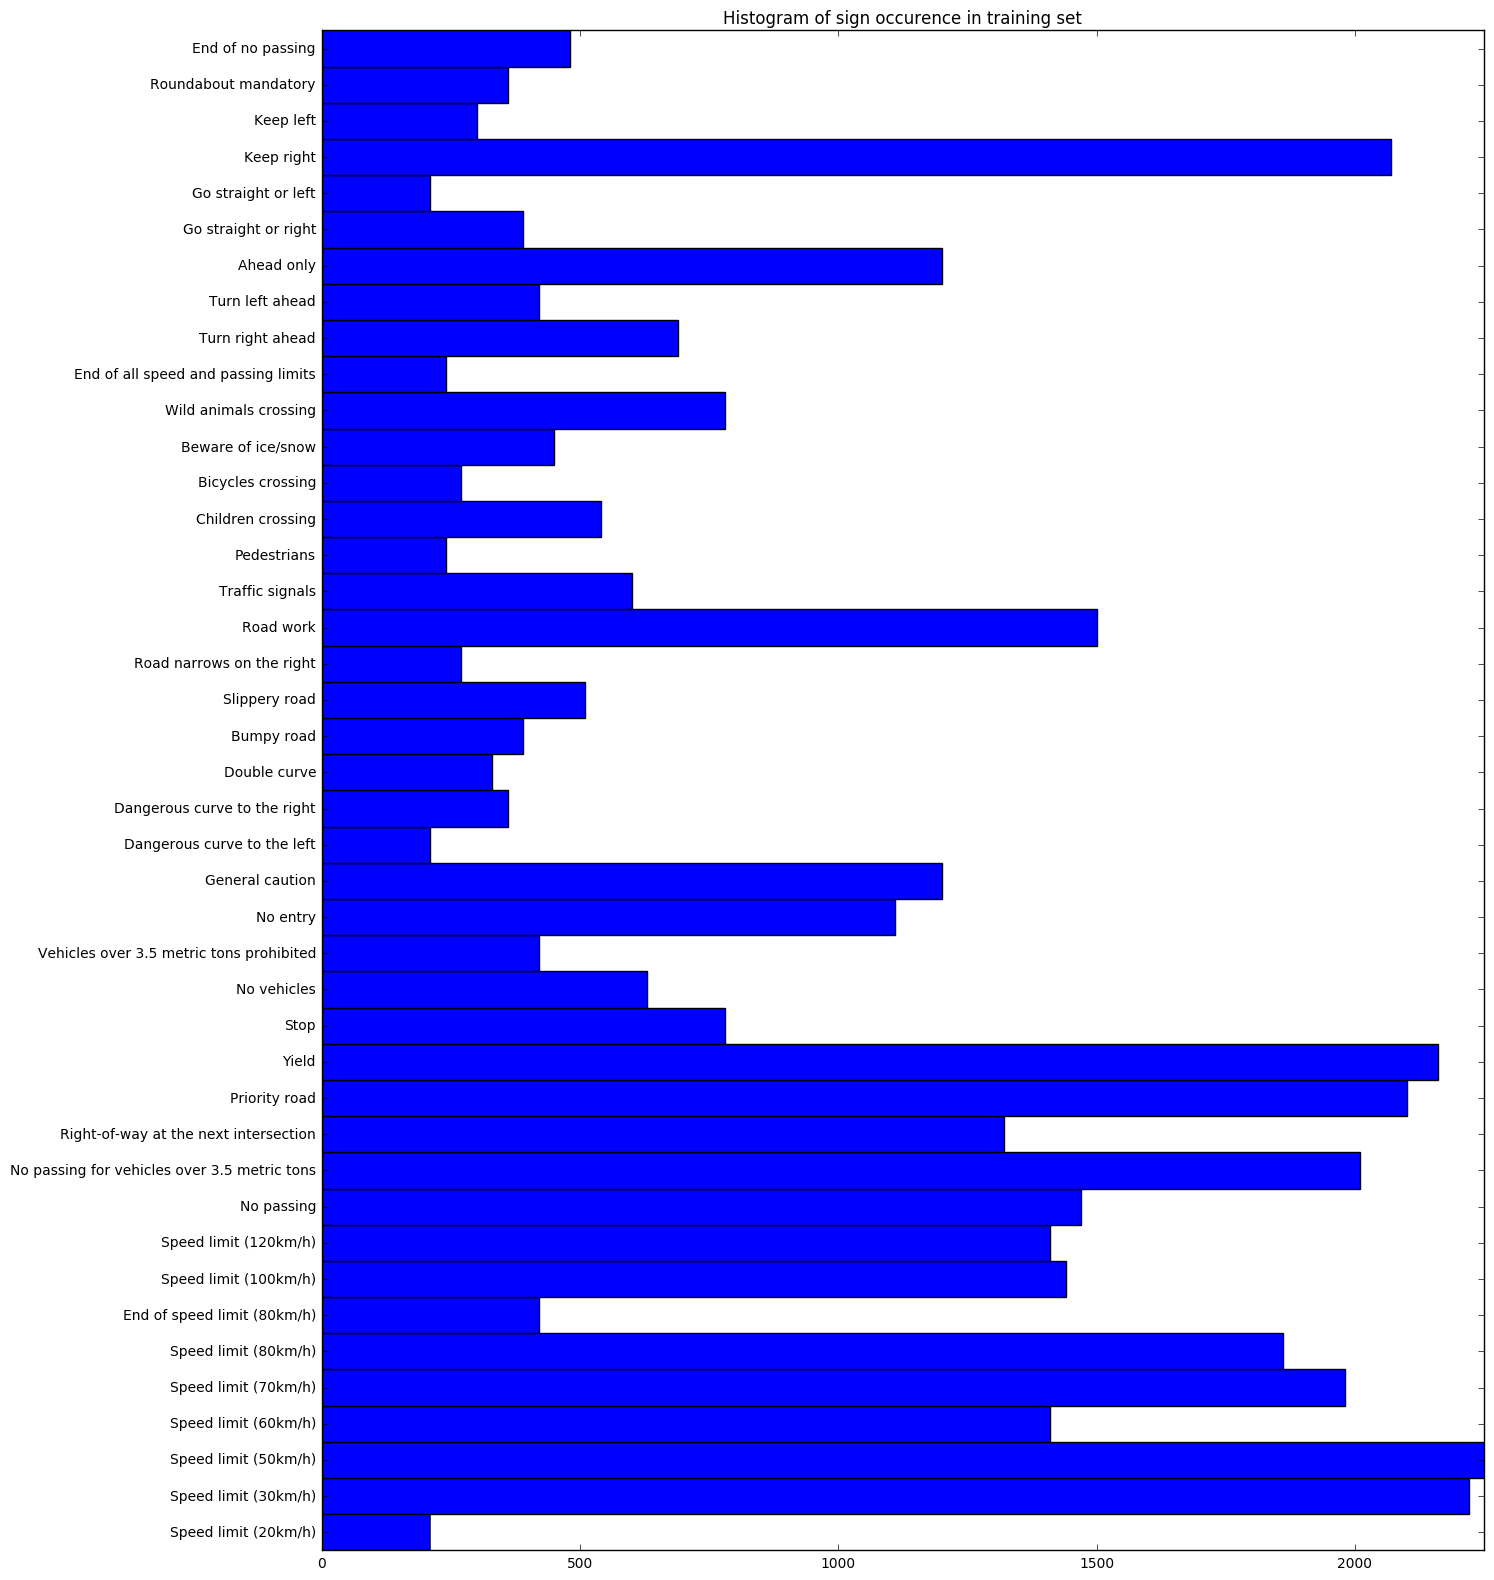

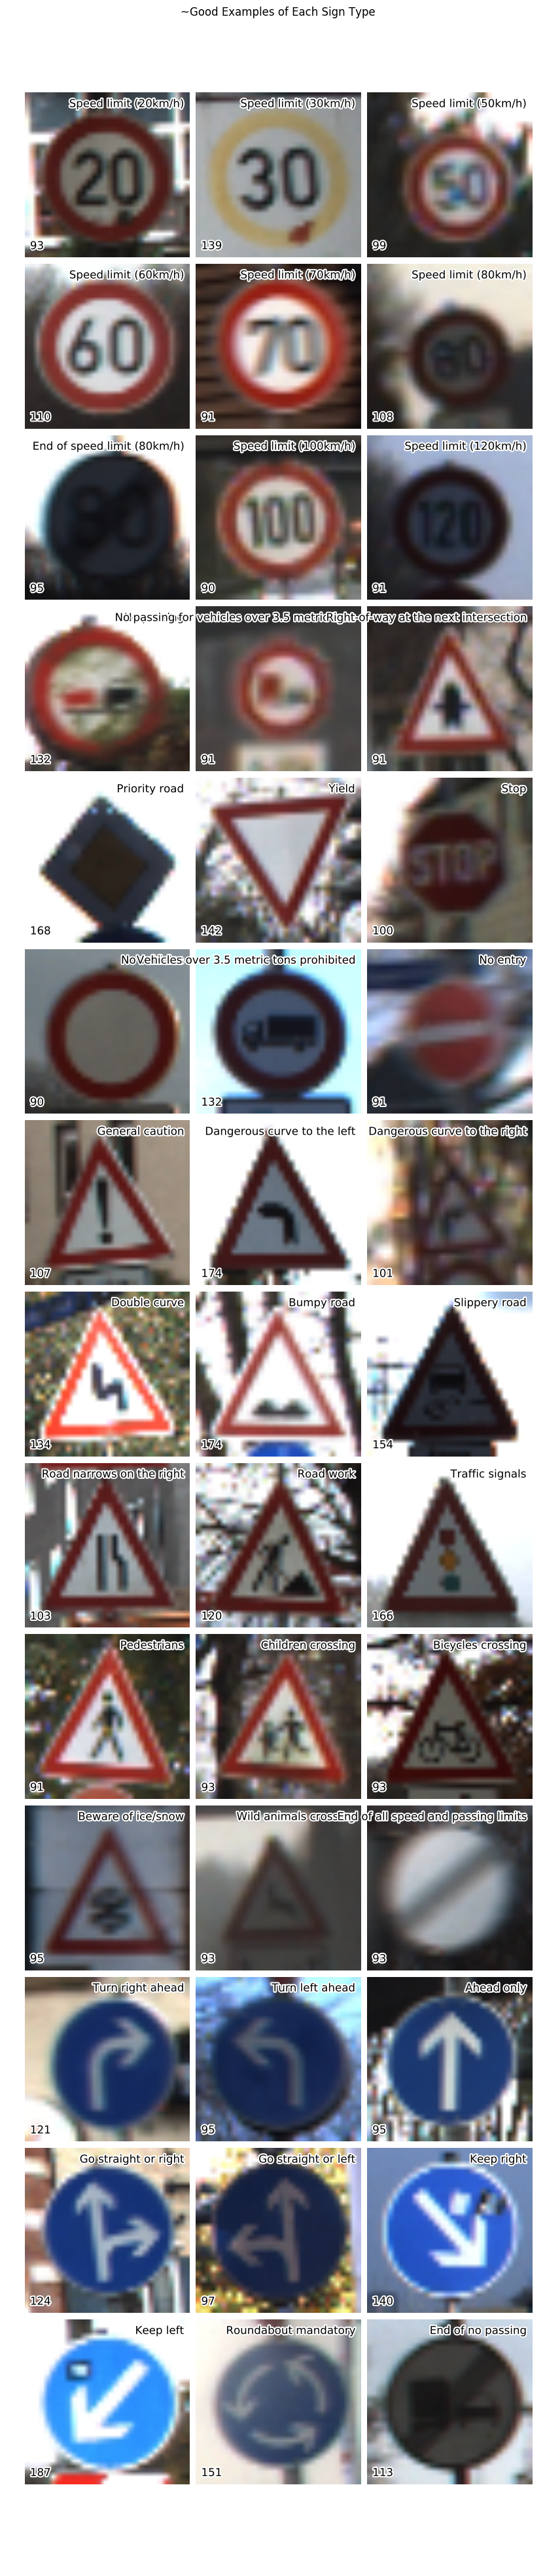

In [6]:
import numpy as np
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
from operator import itemgetter

# Visualizations will be shown in the notebook.
%matplotlib inline

def show_hist():
    fig, ax = plt.subplots()
    fig.set_size_inches(15., 38.)
    N, bins, patches = ax.hist(y_train, 42, orientation='horizontal', align='left')
    # Label ticks match/map class numbers/sign names
    ticks = range(n_classes)
    plt.yticks(ticks, list(map(lambda x: sign_dict[str(x)], ticks)), rotation='horizontal')
    plt.margins(0.0)
    plt.title('Histogram of sign occurence in training set')
    plt.subplots_adjust(bottom=0.50)
    plt.show()
    return N, bins

def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

def sign_brightness(image):
    pixels = np.reshape(image, [image.shape[0]*image.shape[1], 3])
    grey = list(map(lambda x: np.mean(x), pixels))
    return np.mean(grey)

num_signs, bins = show_hist()

def plot_signs(num_signs):
    offset = 1000
    fig, ax = plt.subplots()
    ax.set_axis_off()
    plt.title("~Good Examples of Each Sign Type")
    fig.set_size_inches(10, 50)
    # Display examples of signs in a grid
    grid = ImageGrid(fig, 111, nrows_ncols=(14, 3), axes_pad=0.1,)

    threshold = 90 # The mean pixel magnitude across RGB for all pixels in an image (correlates to brightness)
    for i in range(n_classes):
        index = y_train.tolist().index(i)
        occur = int(num_signs[i]) - 1 # The last example in the training set
        # Loop through at most all training examples
        while(occur >= 0):
            sign_to_test = X_train[index + occur] # sign image under test for brightness
            pixel_mean = sign_brightness(sign_to_test)
            if(pixel_mean > threshold):
                grid[i].imshow(sign_to_test)
                grid[i].set_axis_off()
                title = sign_dict[str(i)]
                add_inner_title(grid[i], "%2d" % (pixel_mean), loc=3)
                add_inner_title(grid[i], "%s" % (title), loc=1)
                break
            occur = occur - 1
    plt.show()
    
plot_signs(num_signs)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
import numpy as np
from sklearn.utils import shuffle

import cv2
ROT_LOW = -20
ROT_HIGH = 20

def rotate_image(image, angle):
    rows,cols,ch = image.shape 
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(image, M, (cols,rows))

"""
Fill in sign types that are underrepresented with rotated version of self
"""
def add_rotated_filler(n_classes, num_signs, justify, x, y):
    tmp_x = np.array(x, copy=True)
    tmp_y = np.array(y, copy=True)
    for i in range(n_classes):
        first_index = y.tolist().index(i)
        num_occur = int(num_signs[i])
        offset = first_index
        print(sign_dict[str(i)])
        #print(num_occur, offset, justify)
        index = 0
        while(index < (justify - num_occur)):
            if (offset > num_occur):
                offset = first_index
            working_x = x[offset]
            working_y = y[offset]
            rot = np.random.randint(ROT_LOW, high=ROT_HIGH)
            r_image = rotate_image(working_x, rot)
            tmp_x = np.concatenate((tmp_x, np.array([r_image])))
            tmp_y = np.append(tmp_y, working_y)
            index = index + 1
            offset = offset + 1
        final_index = len(tmp_y) - 1
    return tmp_x, tmp_y

print (X_train.shape, y_train.shape)
justify = int(max(num_signs))

# Add Generated Data to training set, and prepare to save
#X_check, y_check = add_rotated_filler(n_classes, num_signs, justify, X_train, y_train)

In [9]:
training_file_w_gen = '/notebooks/train_gen.p'

In [ ]:
# Load pickled data
import pickle

def save_gen_data():
    save_dict = {}
    save_dict['features'] = X_check
    save_dict['labels'] = y_check
    with open(training_file_w_gen, mode='wb') as f:
        pickle.dump(save_dict, f)

#save_gen_data()

In [10]:
with open(training_file_w_gen, mode='rb') as f:
    train_gen = pickle.load(f)

X_train, y_train = train_gen['features'], train_gen['labels']

print (X_train.shape, y_train.shape)

(94500, 32, 32, 3) (94500,)


In [11]:
X_train_s, y_train_s = shuffle(X_train, y_train)

### Question 1 

What preprocessing techniques are used?

In [12]:
from sklearn.model_selection import train_test_split

X_test_s, X_validation, y_test_s, y_validation = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

print (X_train_s.shape, X_test_s.shape, X_validation.shape)

(94500, 32, 32, 3) (8462, 32, 32, 3) (4168, 32, 32, 3)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

# Answer Q1: Data Generation & Shuffling

I chose to generate datapoints, and to shuffle the training data. 

## Generating new data
The generated datapoints are included to normalize the distribution of examples of each sign type. If you look at the histogram "sign occurence in the training set" you will see that some signs have much fewer examples. An uneven distribution makes it difficult for the optimizer to determine the actual accuracy for a given sign prediction. So, normalizing the distribution will make the model more accurate.  

## Shuffling
The images data are stored in the pickle file in order, as if a car approaching the signs, the signs get closer and larger with each new data point. Shuffling the data prevents the neural network from learning to depend on images being presented in order. In practice, signs can appear at any moment, as the car turns and things come into view, and out of view. 

# Answer Q2: Splitting test data into test and validation sets
I setup the training, testing, and validation sets, by splitting the testing data into two parts, using 33% of the test data for validation. I did this to make sure that as I manually tweaked hyperparameters, I was avoiding overfitting the test data. 

In later stages I played around with grayscale, brightness, and contrast of the images: but that was done randomly at runtime.

In [13]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from math import ceil

# BrianNet: 
Like LeNet, with more neurons and 3 channels of color

In [14]:
def conv2d(filter_size, filter_depth, strides, x, padding='VALID'):
    layer_filter = tf.Variable(tf.truncated_normal(filter_size))
    layer_bias = tf.Variable(tf.zeros(filter_depth))
    conv = tf.nn.conv2d(x, layer_filter, strides=strides, padding=padding)
    layer = tf.nn.bias_add(conv, layer_bias)
    return layer

def hidden(in_size, out_size, dropout, x):
    fc_W = tf.Variable(tf.truncated_normal([in_size, out_size]))
    fc_b = tf.Variable(tf.zeros(out_size))
    fc = tf.add(tf.matmul(x, fc_W), fc_b)
    #relu = tf.nn.relu(fc)
    dropout = tf.nn.dropout(fc, dropout)
    return dropout

In [41]:
in_height = 32
in_width = 32

# Image tuning/pre-processing parameters 
brightness_delta = 50
contrast_low = 50
contrast_high = 100

# CNN Layer 1
filter_1_depth = 90
filter_1 = [3, 3, 3, filter_1_depth]
filter_1_strides = [1, 1, 1, 1]
# Pool 1
pool_1_ksize = [1, 2, 2, 1]
pool_1_strides = [1, 2, 2, 1]

# CNN Layer 2
filter_2_depth = 150
filter_2 = [5, 5, filter_1_depth, filter_2_depth]
filter_2_strides = [1,1,1,1]
# Pool 2
pool_2_ksize = [1, 3, 3, 1]
pool_2_strides = [1, 1, 1, 1]

out_height_1 = ceil(float(in_height - filter_1[1])/float(filter_1_strides[2])) + 1
out_width_1 = ceil(float(in_width - filter_1[0])/float(filter_1_strides[1])) + 1
pool_out_height_1 = ceil(float(out_height_1 - pool_1_ksize[1]) / float(pool_1_strides[1])) + 1
pool_out_width_1 = ceil(float(out_width_1 - pool_1_ksize[2]) / float(pool_1_strides[2])) + 1

out_height_2 = ceil(float(pool_out_height_1 - filter_2[0])/float(filter_2_strides[1])) + 1
out_width_2 = ceil(float(pool_out_width_1 - filter_2[1])/float(filter_2_strides[2])) + 1
pool_out_height_2 = ceil(float(out_height_2 - pool_2_ksize[1]) / float(pool_2_strides[1])) + 1
pool_out_width_2 = ceil(float(out_width_2 - pool_2_ksize[2]) / float(pool_2_strides[2])) + 1

# Fully Connected layers
hidden_1_size = pool_out_height_2 * pool_out_width_2 * filter_2_depth

hidden_2_size = 100
hidden_3_size = 100
fc_1_size = 100
O_size = 42

# Hyperparameters
epochs = 55
batch_size = 128
learning_rate = 0.00015

print('CNN 1:', out_height_1, out_width_1)
print('Pool 1:', pool_out_height_1, pool_out_width_1)
print('CNN 2:', out_height_2, out_width_2)
print('Pool 2:', pool_out_height_2, pool_out_width_2)
print ('Hidden 1:', hidden_1_size)

CNN 1: 30 30
Pool 1: 15 15
CNN 2: 11 11
Pool 2: 9 9
Hidden 1: 12150


In [42]:

def BrianNet(x, keep_prob):
    x = tf.image.adjust_brightness(x, delta=40)
    #x = tf.image.random_brightness(x, max_delta=brightness_delta)
    #x = tf.image.random_contrast(x, contrast_low, contrast_high)
    
    # Convolutions
    layer_1 = conv2d(filter_1, filter_1_depth, filter_1_strides, x)
    relu_1 = tf.nn.relu(layer_1)
    pool_1 = tf.nn.max_pool(relu_1, ksize=pool_1_ksize, strides=pool_1_strides, padding='VALID')
    
    layer_2 = conv2d(filter_2, filter_2_depth, filter_2_strides, pool_1)
    relu_2 = tf.nn.relu(layer_2)
    pool_2 = tf.nn.max_pool(relu_2, ksize=pool_2_ksize, strides=pool_2_strides, padding='VALID')
    
    # Flatten. 
    flat_1 = tf.reshape(pool_2, [-1, hidden_1_size])
    
    # Hiddens
    h_1 = hidden(hidden_1_size, hidden_2_size, keep_prob, flat_1)
    h_2 = hidden(hidden_2_size, fc_1_size, keep_prob, h_1)
    #h_3 = hidden(hidden_3_size, fc_1_size, keep_prob, h_2)
    
    # Fully Connected => 42 classes
    fc_O_W = tf.Variable(tf.truncated_normal([fc_1_size, O_size]))
    fc_O_b = tf.Variable(tf.zeros(O_size))
    logits = tf.add(tf.matmul(h_2, fc_O_W), fc_O_b)
    
    return logits

# One Hot Encoding
One hot encoding the label data ensures that the scalar quality of the labels does not imply some ordering.

In [43]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

In [44]:
logits = BrianNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

The following evaluation code was taken from the LeNet exercise we did earlier.

In [45]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [46]:
config=tf.ConfigProto()#log_device_placement=True)
def train_model():
    with tf.Session(config=config) as sess:
        print ("Initializing variables...")
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_s)
        print("Training...")
        print()
        for i in range(epochs):
            X_train_l, y_train_l = shuffle(X_train_s, y_train_s)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train_l[offset:end], y_train_l[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))

        saver.save(sess, 'briannet')
        print("Model saved")
train_model()

Initializing variables...
Training...

EPOCH 1 Validation Accuracy = 0.140
EPOCH 2 Validation Accuracy = 0.255
EPOCH 3 Validation Accuracy = 0.337
EPOCH 4 Validation Accuracy = 0.418
EPOCH 5 Validation Accuracy = 0.454
EPOCH 6 Validation Accuracy = 0.487
EPOCH 7 Validation Accuracy = 0.532
EPOCH 8 Validation Accuracy = 0.552
EPOCH 9 Validation Accuracy = 0.582
EPOCH 10 Validation Accuracy = 0.606
EPOCH 11 Validation Accuracy = 0.633
EPOCH 12 Validation Accuracy = 0.652
EPOCH 13 Validation Accuracy = 0.679
EPOCH 14 Validation Accuracy = 0.687
EPOCH 15 Validation Accuracy = 0.702
EPOCH 16 Validation Accuracy = 0.723
EPOCH 17 Validation Accuracy = 0.731
EPOCH 18 Validation Accuracy = 0.740
EPOCH 19 Validation Accuracy = 0.748
EPOCH 20 Validation Accuracy = 0.762
EPOCH 21 Validation Accuracy = 0.768
EPOCH 22 Validation Accuracy = 0.770
EPOCH 23 Validation Accuracy = 0.786
EPOCH 24 Validation Accuracy = 0.800
EPOCH 25 Validation Accuracy = 0.802
EPOCH 26 Validation Accuracy = 0.802
EPOCH 27

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


# Answer Q3
## My Architecture
My architecture is very similar to the Le Net architecture. However, I made some changes to accomodate the usage of three color channels, and to deal with more complex shapes present in signs.

### Like LeNet
![Le Net](./lenet_architecture.png)
Above is the LeNet architecture.

### Description
In the BrianNet architecture there are two convolutional layers, each with an activation and a pooling layer. After that, the nodes are flattened to a one dimensional array, and three fully connected layers follow. The key differences with the LeNet architecture are the presence of a few extra hidden fully connected layers, and the varying sizes of each of the layers.



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


# Answer Q5:
I trained my model by running 60 epochs, in batches of 128. I used a learning rate of 0.0001. I used many of the training methods, including the same corss entropy, loss operation, optimizer, training operation, and accuracy operation from the LeNet exercise.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

# Answer Q5

## Building BrianNet
BrianNet is very similar to LeNet architecture, with a few tweaks to each layer's dimensions. I found that LeNet alone did not do very well on the sign data. 

### Input Manipulation
I started by playing around with grayscale, and random deltas for both brightness and contrast. I ended up keeping the 3 RGB color channels. I am not sure whether the color channels had a positive impact, because I changed the filter and layer sizes after including colors, and only then did I start to see improvements.

### Filter Sizes
My Network has two convoliutional layers. I played around with several filter size combinations. I tried several filter sizes that worked well enough, 1x1, 3x3, and 5x5. I had to try to make sure the output

### FIlter Depths
Filter depths represent the number of shapes, and in later stages, combinations of shapes. I tooks some wild approximations of the nuimber of important features in the sign data. For instance, many of the signs have a curved line, number, arrow head, or some other symbol. I needed enough filter depth in the 2nd Convolutional layer to represent each higher order shape, and enough filter depth in the layer 1 Convolutionallayer to represent the primitives of those shapes. I ended up with the values in filter_1_depth and filter_2_depth. I am sure with more thoughtful contemplation, I could determine the correct filter depths more precisely. These values worked for me.

### Learning Rate
I tweaked the learning rate a lot. I found that getting the value as low as I could and using a lot of epochs to get the best results. As the epochs increased, lower learning rates helped the model to improve by small amounts, but continue to climb in accuracy.

### Normal Distribution
Finally, I realized that the distribution of sign examples in the training set was not normal. In order for the optimizer to find the correct accuracy rates for each sign, either the distribution must be normal or the loss function must take into account the distribution. Adding generated data, with correct labels, and with new aspects, would also improve the model by giving it more chances to learn less prevalent signs. So, for those reasons, I chose to normalize the distribution of images by padding signs with fewer datapoints with rotated version of those signs existing training datapoints.

Here is the normalized distribution of sign types:

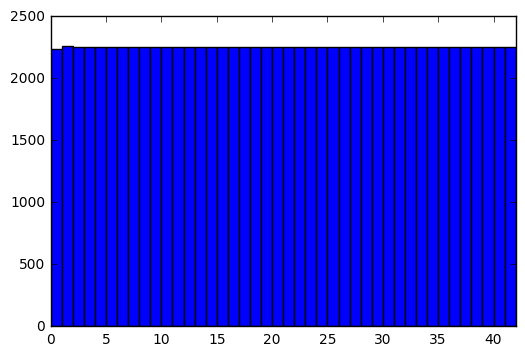

In [36]:
hist, bin_edges = np.histogram(y_train, 42)
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show() 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Start By Seeing How Well We Do On Validation Set

I decided to see how well the model does on the validation set, as a first step. I shuffle the validation set each time this code is run. On top of each image from the validation set, I plot the prediction made, as well as the label. You can see that a ~75% accuracy is not good enough for real world use. There could be some dangerous situations, such as predicting a higher speed limit than the label indicates. 

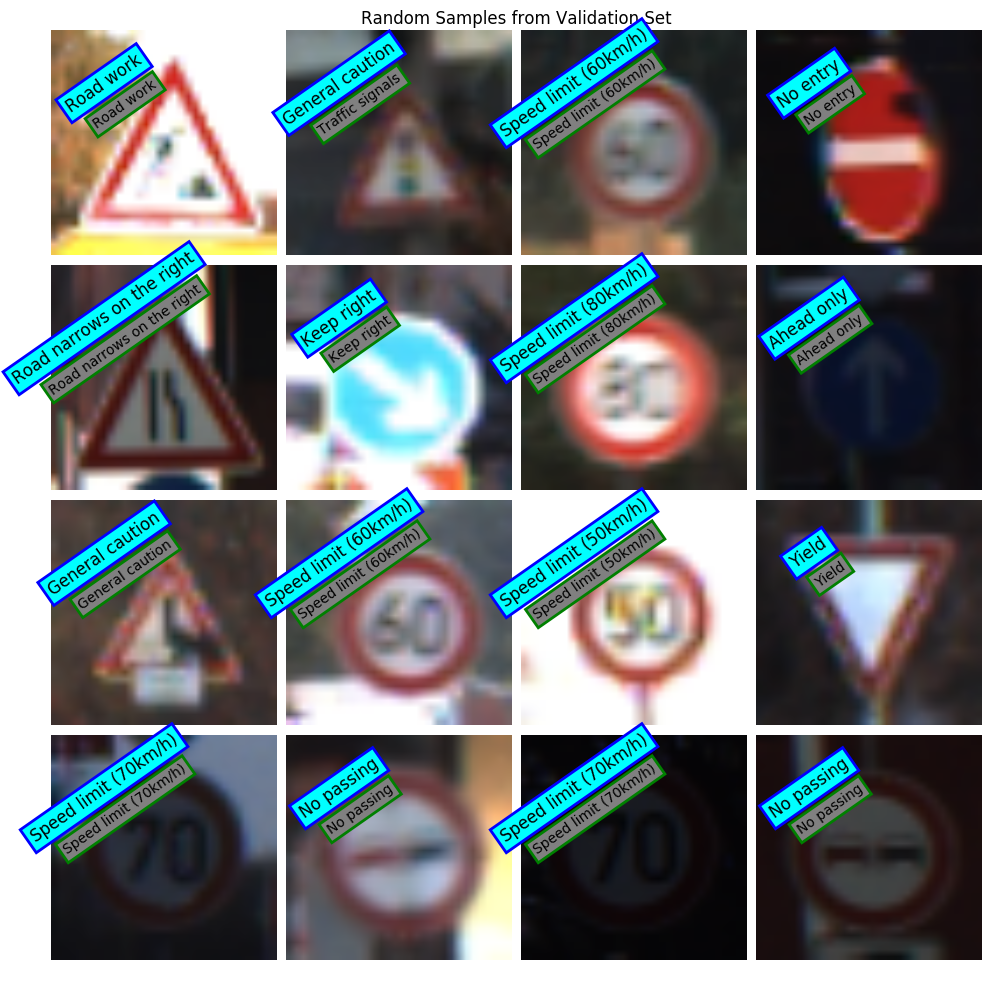

In [48]:
import tensorflow as tf

saver = tf.train.Saver()
answer = tf.argmax(logits, 1)

offset_validate = 0
num_validate = 16

# Display examples of signs in a grid
fig, ax = plt.subplots()
ax.set_axis_off()
plt.title("Random Samples from Validation Set")
fig.set_size_inches(12, 12)
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1,)

x_v, y_v = shuffle(X_validation, y_validation)
end = num_validate + offset_validate
x_v, y_v = x_v[offset_validate:end], y_v[offset_validate:end]

with tf.Session() as sess:
    saver.restore(sess, "./briannet")
    predictions = sess.run(answer, feed_dict={x: x_v, keep_prob: 1.0})

    for i in range(len(predictions)):
        prediction = sign_dict[str(predictions[i])]
        label = sign_dict[str(y_v[i])]
        grid[i].imshow(x_v[i])
        label_props = dict(boxstyle="square,pad=0.3", fc="grey", ec="g", lw=2)
        t = grid[i].text(10, 10, label, ha="center", va="center", rotation=35,size=10, bbox=label_props)
        title_props = dict(boxstyle="square,pad=0.3", fc="cyan", ec="b", lw=2)
        t = grid[i].text(7, 7, prediction, ha="center", va="center", rotation=35,size=12, bbox=title_props)
        grid[i].set_axis_off()
    plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



# Answer Q6:
I downloaded five images of traffic signs from a Google search. All of the German traffic signs should be classifiable: the 30km/hr, 50km/hr, Roundabout mandatory, and yield signs. 

However, the classifier has trouble with most of the nonb-German signs. Two of the non-German signs should be difficult for the model to classify because they are not at all like any of the signs in the training data set: the two US speed limit signs. Another sign that is a German sign, but not in the data set was misclassified: the Bicycle lane sign. Another sign that I found, from the USA, was misclassified as a German "End of Speed Limit (80km/h)" sign, even though the sign is more similar to a German "End of all Speed and Passing Limit" sign. Something about the shape of the diagonal band must have triggered the wrong classification. Finally, a sign from the USA was classified correctly: the Yield sign. That sign is nearly identical to the German version, so the classifier had seen many signs like it before.

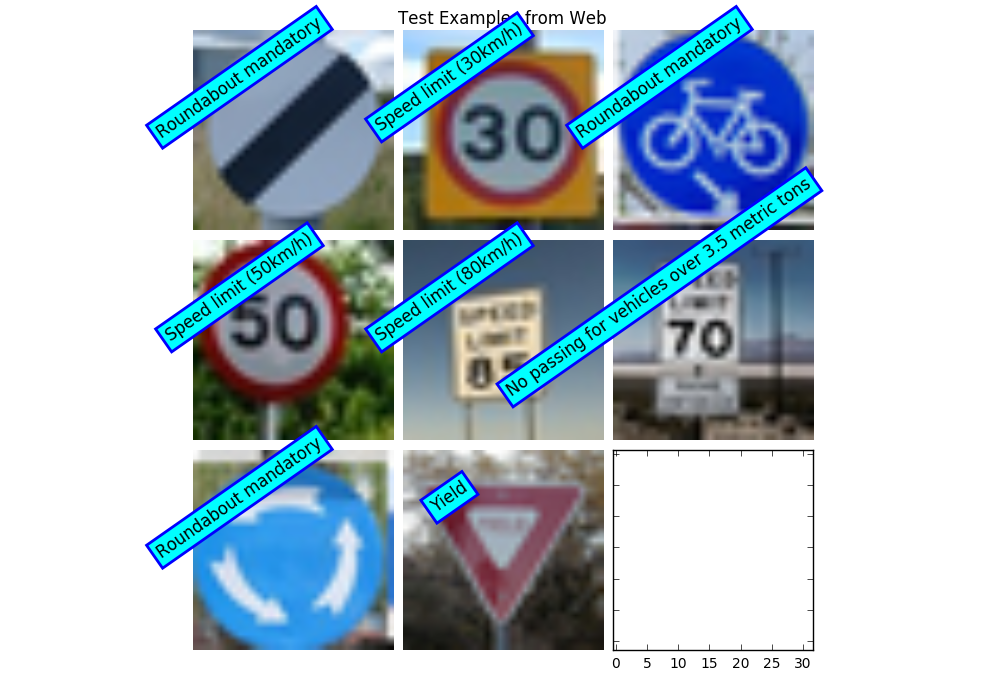

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from PIL import Image
from glob import glob

saver = tf.train.Saver()
answer = tf.argmax(logits, 1)

file_list = glob('./my_signs/*.jpg')
images = np.array([np.array(Image.open(f)) for f in file_list])

fig, ax = plt.subplots()
ax.set_axis_off()
plt.title("Test Examples from Web")
fig.set_size_inches(12, 8)
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.1)

with tf.Session() as sess:
    saver.restore(sess, "/notebooks/briannet")
    predictions = sess.run(answer, feed_dict={x: images, keep_prob: 1.0})
    for i in range(len(predictions)):
        grid[i].imshow(images[i])
        title = sign_dict[str(predictions[i])]
        bbox_props = dict(boxstyle="square,pad=0.3", fc="cyan", ec="b", lw=2)
        grid[i].text(7, 7, title, ha="center", va="center", rotation=35,size=12, bbox=bbox_props)
        grid[i].set_axis_off()
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


# Answer Q7:

My model is 50% accurate on the captured dataset. The model is 87% accurate on the test dataset. The model performs much better on signs that it has seen before. As exhibited in the captured set, the sign types which are present in the training data are classified correctly. However, for the most part, the model fails to classify signs it has never seen before, with the exception of Yield sign. The Yield sign is so similar to ones the model has seen before, that it correctly classifies it.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

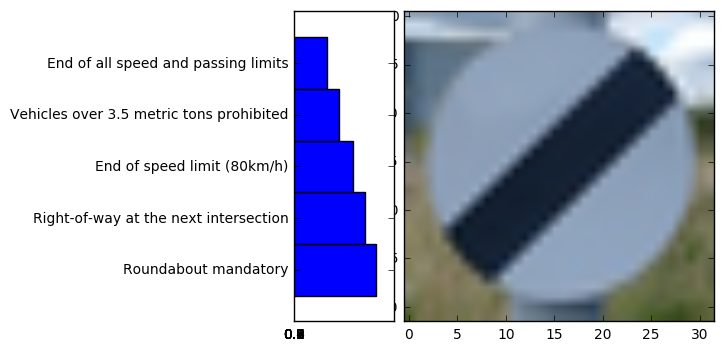

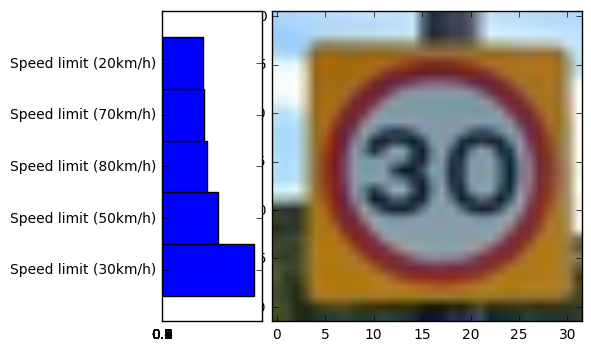

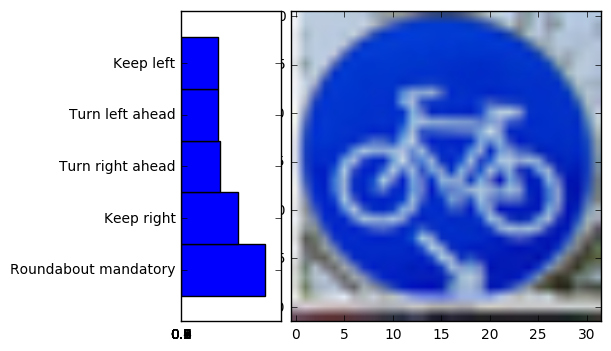

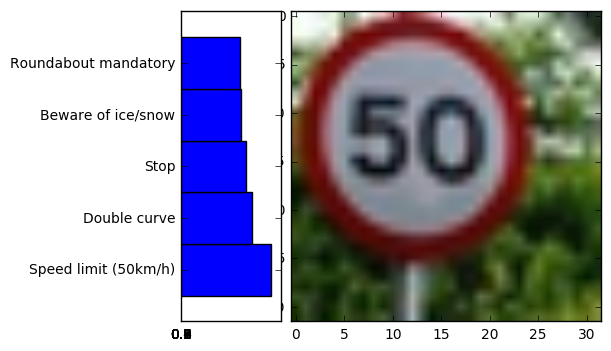

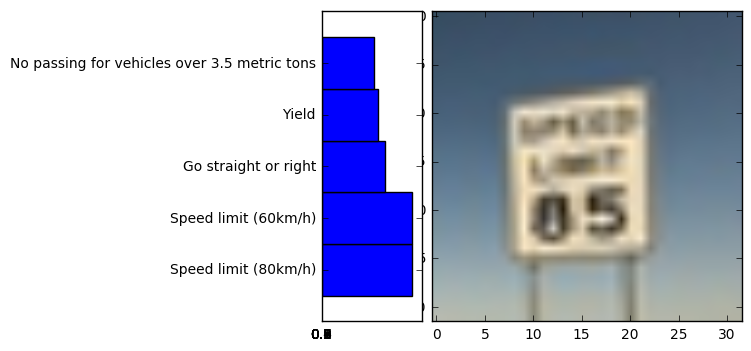

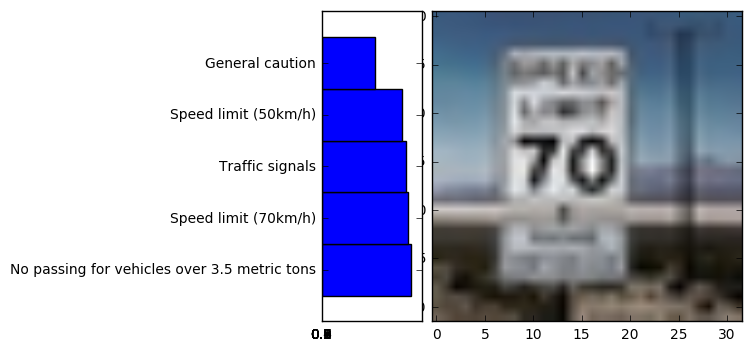

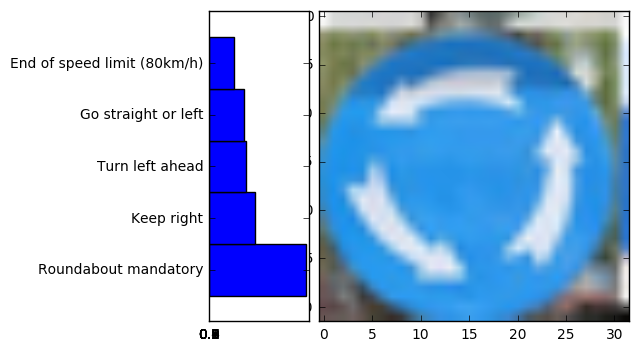

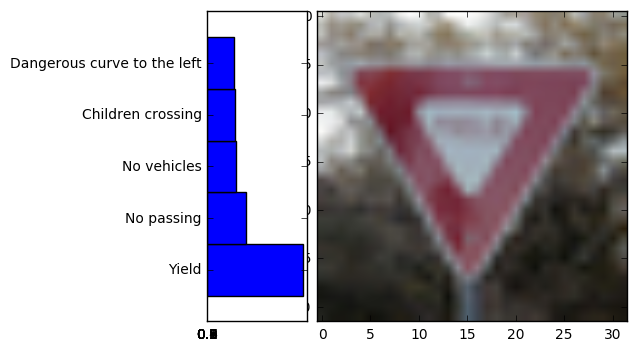

In [51]:
### Visualize the softmax probabilities here.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
from PIL import Image
from glob import glob

saver = tf.train.Saver()

file_list = glob('./my_signs/*.jpg')
images = np.array([np.array(Image.open(f)) for f in file_list])
k = 5
ticks = range(k)
with tf.Session() as sess:
    saver.restore(sess, "/notebooks/briannet")
    softmax = tf.nn.softmax(logits)
    top_k_op = tf.nn.top_k(logits, k=k) 
    top_k = sess.run(top_k_op, feed_dict={x: images, keep_prob: 1.0})
    for i in range(len(images)):
        sign = plt.subplot(111)
        sign.imshow(images[i])
        divider = make_axes_locatable(sign)
        hist = divider.append_axes("left", size=1.0, pad=0.1)
        hist.barh(ticks, top_k.values[i], align='center',height=1.0)
        hist.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
        hist.set_yticks(ticks)
        hist.set_yticklabels(list(map(lambda x: sign_dict[str(x)], top_k.indices[i])), ha='right')
        plt.show()

# Answer Q8:
Visualizing the softmax probabilities, it can be seen that the model is sure of several of it's classifications.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.